# Подготовка

Имортируем библиотеки, и загрузим данные

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve,\
    confusion_matrix, plot_confusion_matrix, recall_score,\
    precision_score, f1_score, plot_precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from pathlib import Path

from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format

In [2]:
RANDOM_SEED = 13
DATA_PATH = Path('.')

train = pd.read_csv(DATA_PATH/'train.csv')
test = pd.read_csv(DATA_PATH/'test.csv')

train['train'] = 1
test['train'] = 0
test['default'] = 0

df = pd.concat([train, test])
df.set_index('client_id', inplace=True)

In [3]:
df.head(2)

,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
client_id,,,,,,,,,,,,,,,,,,,
25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.01,1,50,1,2,18000,4,1,N,0,1
63161,12MAR2014,SCH,F,59,N,N,0,0,-1.53,3,50,2,3,19000,4,1,N,0,1


# Разведывательный анализ данных 

У нас есть несколько наборов колонок
* Количественные: ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki', 'region_rating']
* Бинарные: ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
* Категориальные: ['education', 'home_address', 'work_address', 'sna', 'first_time']
* Дата - app_date

In [4]:
df.isna().sum().sort_values(ascending=False)

education           478
train                 0
score_bki             0
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
bki_request_cnt       0
default               0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
app_date              0
dtype: int64

Только в колонке **education** есть пропуски. Заполним их самым популярным значением. Их ведь не очень много.

In [5]:
df.education.value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [6]:
df.education.fillna('SCH', inplace=True)

In [7]:


def plot_cat_plot(column_name):
    sns.catplot(
        data=df[df.train == 1],
        kind="bar",
        x=column_name,
        y="default",
        palette="dark",
        alpha=.6,
        height=6
    )
    plt.title(f'Распределение процентов дефолта в зависимости от {column_name}')
    plt.show()

## Количественные переменные

### age

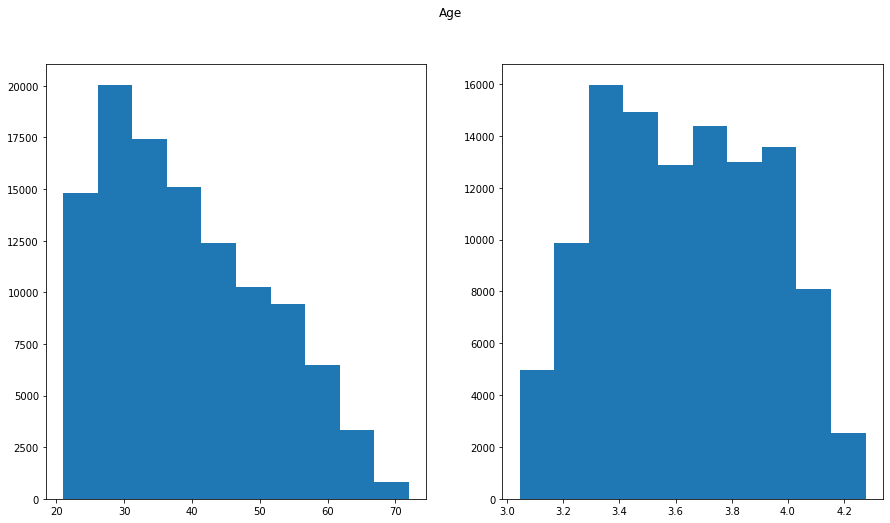

In [8]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.hist(df.age)
ax2.hist(np.log(df.age))
figure.suptitle('Age')
plt.show()

прологарифмируем колонку, т.к. так лучше она более "нормальная"

### decline_app_cnt

In [9]:
df.decline_app_cnt.value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
30        1
15        1
19        1
20        1
21        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64

In [10]:
np.sum(df.decline_app_cnt>6)

173

ну очень длинный хвост распределения, давайте все что больше 6 запишем в 7
ну и я бы добавил фичу "decline_app_cnt = 0" проверим как меняется график отказов с ней и без нее

In [11]:
df['decline_app_cnt_is_0'] = df.decline_app_cnt == 0

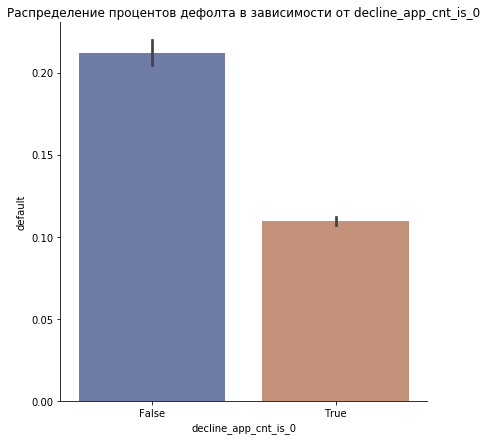

In [12]:
plot_cat_plot("decline_app_cnt_is_0")

### income

In [13]:
df.income.describe()

count    110148.00
mean      41012.65
std       45399.74
min        1000.00
25%       20000.00
50%       30000.00
75%       48000.00
max     1000000.00
Name: income, dtype: float64

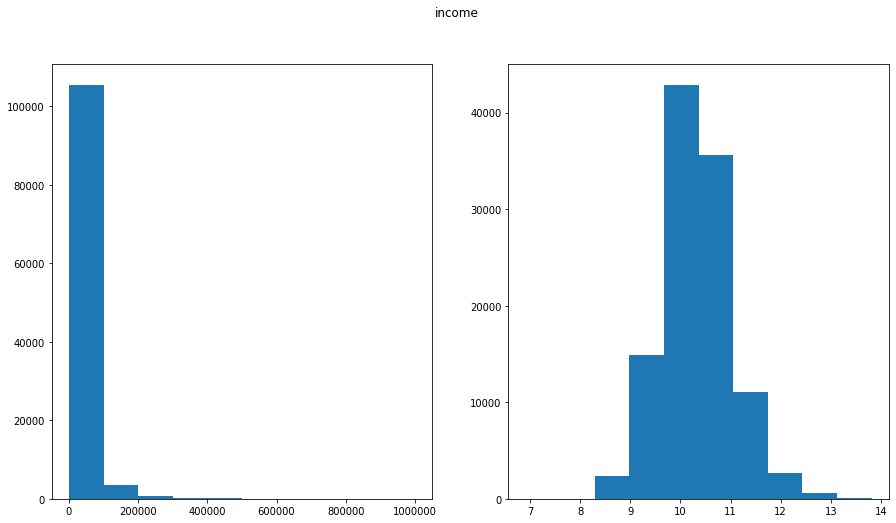

In [14]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.hist(df.income)
ax2.hist(np.log(df.income))
figure.suptitle('income')
plt.show()

Прологарифмируем шкалу, тогда будет более похоже на нормальное распределение  
по логике  чем больше доход, тем меньше вероятность дефолта, давайте посмотрим

In [15]:
df['income_categ'] = pd.cut(df.income,
                                   [1000.00,20000,30000,48000,1000000],
                                   labels=['<20', '20-30', '30-48', '>48'])

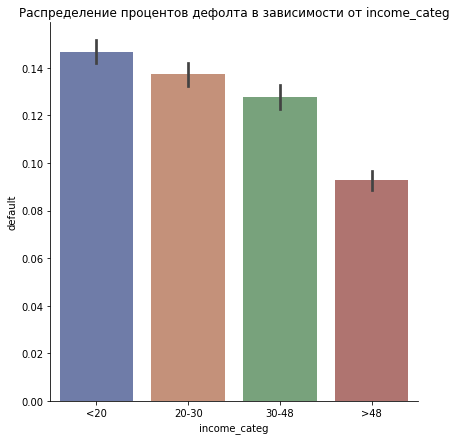

In [16]:
plot_cat_plot("income_categ")

Есть логика в этом предположении, правда среди богатых тоже есть дефолты, но их немного меньше  
Оставим пока оба признака, логарифированный и категориальный, потом посмотрим какой лучше использовать

### bki_request_cnt

In [17]:
df.bki_request_cnt.describe()

count   110148.00
mean         2.01
std          2.27
min          0.00
25%          0.00
50%          1.00
75%          3.00
max         53.00
Name: bki_request_cnt, dtype: float64

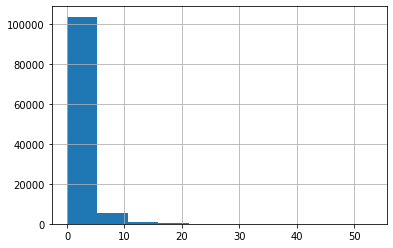

In [18]:
df.bki_request_cnt.hist()

In [19]:
df.bki_request_cnt.value_counts()

0     28908
1     27295
2     20481
3     13670
4      8406
5      4960
6      2500
7      1292
8       735
9       459
10      350
11      278
12      217
13      151
14      110
15       81
16       58
17       33
18       32
19       30
21       19
20       14
23       12
24       12
22        8
25        5
27        5
28        5
26        4
32        4
29        3
33        2
40        2
41        1
46        1
45        1
47        1
36        1
34        1
53        1
Name: bki_request_cnt, dtype: int64

Колонка похожа на decline_app_cnt, попробую сделать также  
Обрежем все что больше 14  
и для 0 сделаем отдельную переменную

In [20]:
df['bki_request_cnt_is_0'] = df.bki_request_cnt == 0

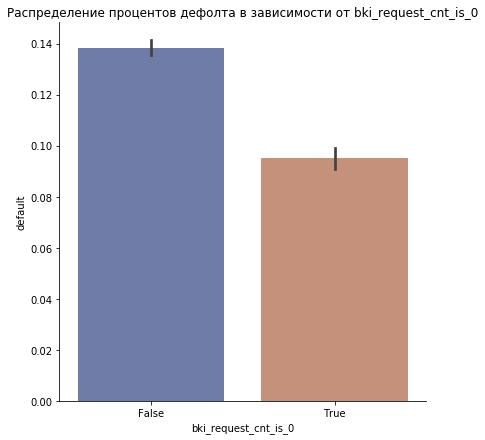

In [21]:
plot_cat_plot("bki_request_cnt_is_0")

### score_bki

In [22]:
df.score_bki.describe()

count   110148.00
mean        -1.90
std          0.50
min         -3.62
25%         -2.26
50%         -1.92
75%         -1.57
max          0.20
Name: score_bki, dtype: float64

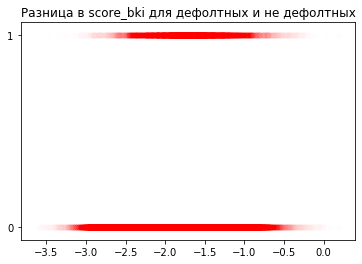

In [23]:
plt.scatter(df.score_bki, df.default, alpha=.002, color='r')
plt.yticks([0,1])
plt.title('Разница в score_bki для дефолтных и не дефолтных')
plt.show()

Видно что для дефолтных значение оценки бки немног смещено к нулю, наверное это будет значимой информацией  
Оставим переменную как есть

### region_rating

In [24]:
df.region_rating.value_counts()

50    40981
60    23999
40    17947
80    17170
70     9304
30      434
20      313
Name: region_rating, dtype: int64

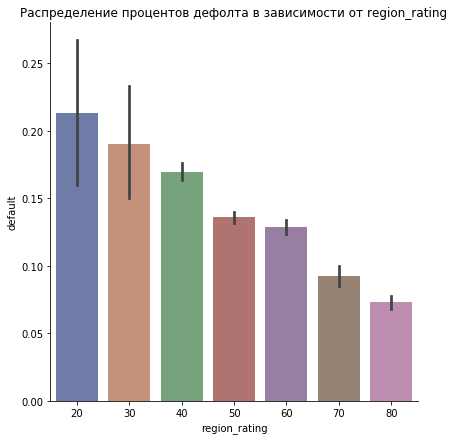

In [25]:
plot_cat_plot('region_rating')

Хорошая переменная, чем выше рейтинг тем реже случаются дефолты.  
Оставляем как есть

## Категориальные переменные (в том числе бинарные)

Будем делить на номинальные переменные и ординальные. Для ординальных сделаем числовые значеия. Для ординальных dummy колонки

* Бинарные: ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
* Категориальные: ['education', 'home_address', 'work_address', 'sna', 'first_time']

### sex

In [26]:
df.sex.value_counts()

F    61836
M    48312
Name: sex, dtype: int64

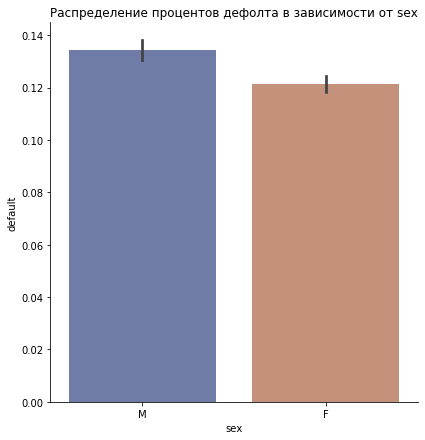

In [27]:
plot_cat_plot('sex')

Маленькая разница, можно даже выкинуть этот параметр, очень уж маленькая разница

### car и car_type 

In [28]:
df.car.value_counts()

N    74290
Y    35858
Name: car, dtype: int64

In [29]:
df.car_type.value_counts()

N    89140
Y    21008
Name: car_type, dtype: int64

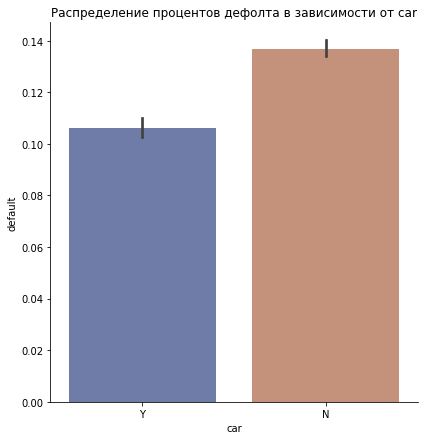

In [30]:
plot_cat_plot('car')

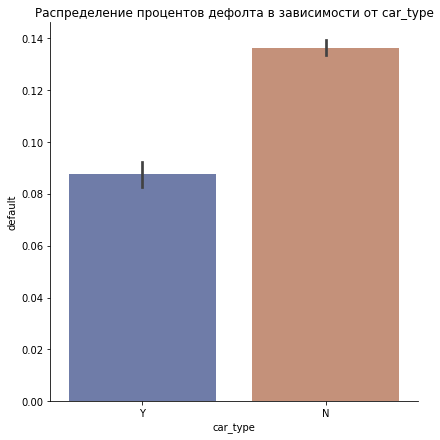

In [31]:
plot_cat_plot('car_type')

In [32]:
df['carcartype'] = df.car+df.car_type

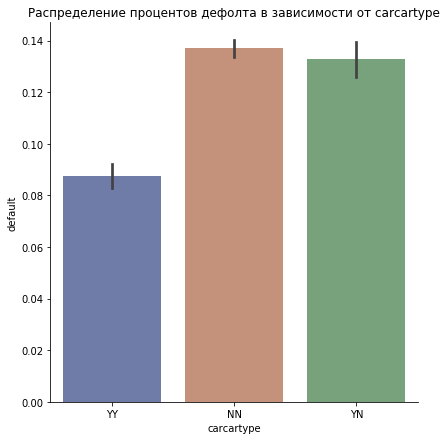

In [33]:
plot_cat_plot('carcartype')

In [34]:
df.carcartype.value_counts()

NN    74290
YY    21008
YN    14850
Name: carcartype, dtype: int64

In [35]:
df.loc[df.carcartype == 'YN','carcartype'] = 'NN'

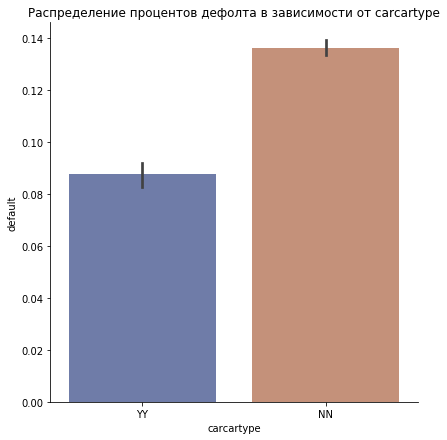

In [36]:
plot_cat_plot('carcartype')

обединим два показателя в один  
но т.к. распределние показало что процент дефолтов у тех кто не указал тип авто такой же как у тех, кто укзазал что авто нету  
то оставим только 2 типа - есть авто и указал тип, и нету авто, тогда проценты дефолтов у этих категорий различаются


### good_work

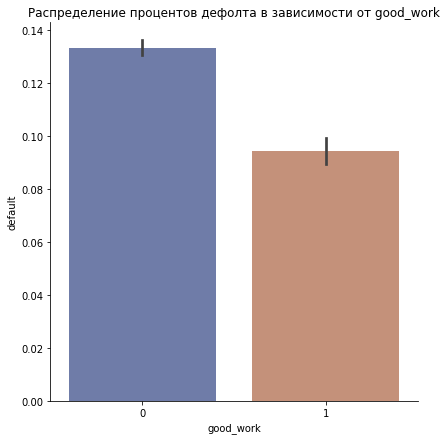

In [37]:
plot_cat_plot('good_work')

Хороший признак, так и осталяем

### foreign_passport

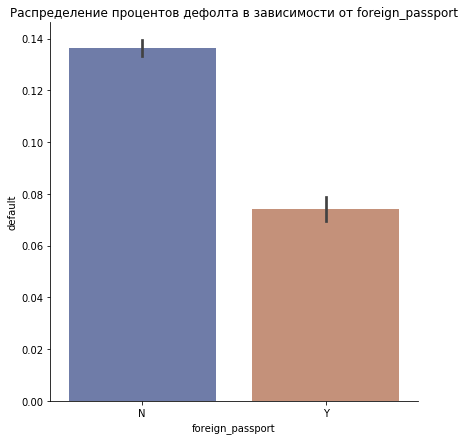

In [38]:
plot_cat_plot('foreign_passport')

Хороший признак, оставляем

### education

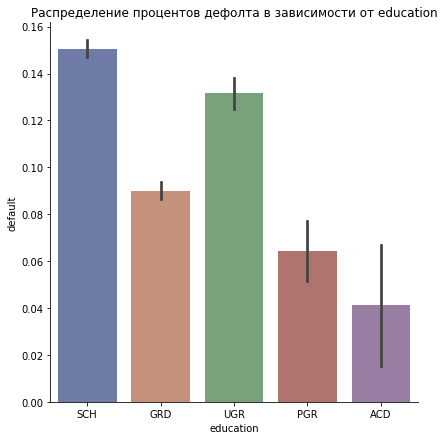

In [39]:
plot_cat_plot('education')

Чаще дефолты у школьников, у академиков (или что такае ACD) - значительно ниже

### home_address

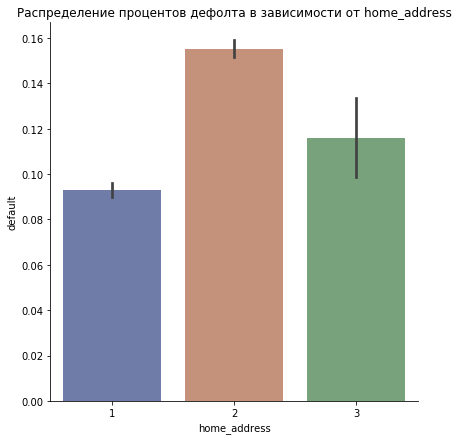

In [40]:
plot_cat_plot('home_address')

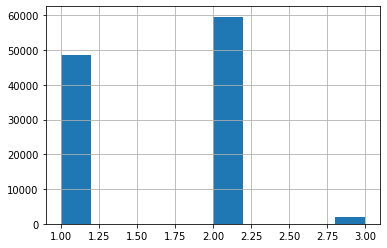

In [41]:
df.home_address.hist();

Хороший признак, осталяем

### work_address

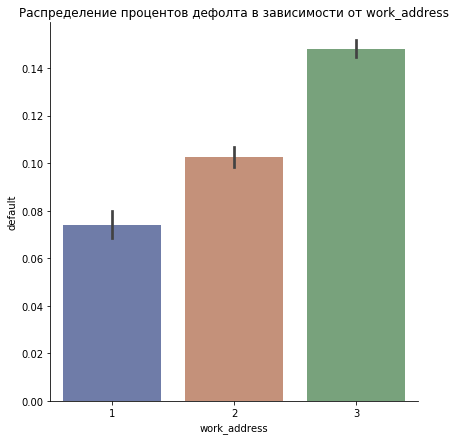

In [42]:
plot_cat_plot('work_address')

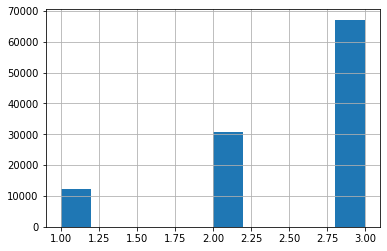

In [43]:
df.work_address.hist();

Хороший признак - оставляем

### sna

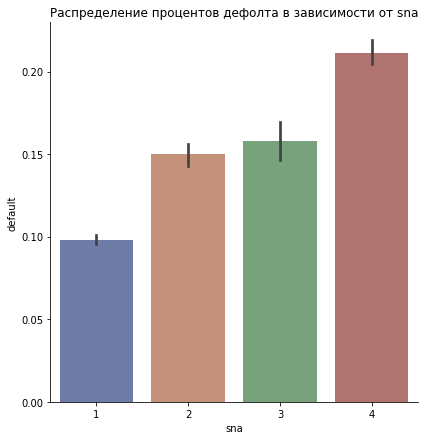

In [44]:
plot_cat_plot('sna')

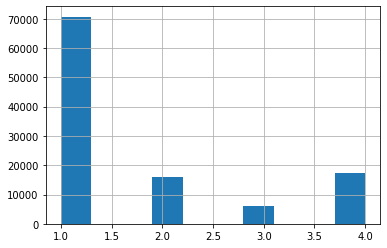

In [45]:
df.sna.hist();

Хороший признак - оставляем

### first_time

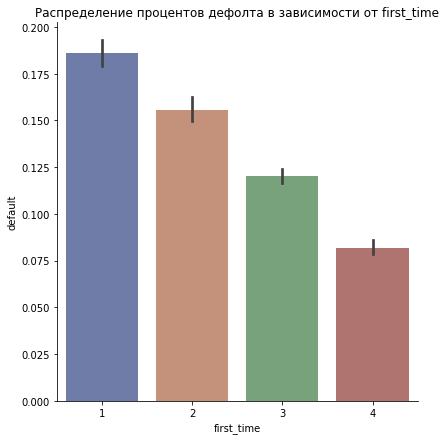

In [46]:
plot_cat_plot('first_time')

Хороший признак оставляем

## app_date

In [47]:
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')

In [48]:
df['app_month'] = df.app_date.dt.month

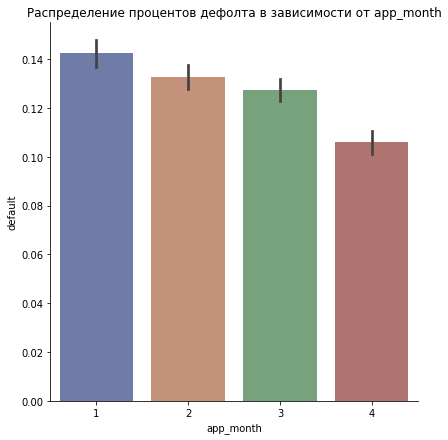

In [49]:
plot_cat_plot('app_month')

# Подготовка датасета

In [50]:
def prepare_data(source):
    df = source.copy()
    df.age = np.log(df.age)
    
    df['decline_app_cnt_is_0'] = (df.decline_app_cnt == 0).astype(int)
    df.decline_app_cnt[df.decline_app_cnt > 6] = 7.
    
    df['income_categ'] = pd.cut(df.income,
                                [1000.00,20000,30000,48000,1000001],
                                labels=[0, 1, 2, 3],
                                include_lowest=True).astype(int)
    df.income = np.log(df.income)
    
    df['bki_request_cnt_is_0'] = (df.bki_request_cnt == 0).astype(int)
    df.bki_request_cnt_is_0[df.bki_request_cnt_is_0 > 14] = 15
    
    df['carcartype'] = df.car + df.car_type
    df.loc[df.carcartype == 'YN','carcartype'] = 'NN'
    df.carcartype = (df.carcartype == 'YY').astype(int)
    
    df.sex = (df.sex == 'M').astype(int)
    
    df.foreign_passport = (df.foreign_passport == 'Y').astype(int)
    
    df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')
    df['month'] = df.app_date.dt.month
    
    df = pd.get_dummies(df, columns=['region_rating','education','home_address','work_address', 'month'])
    
    num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki', 'sna','first_time']

    df[num_cols]= StandardScaler().fit_transform(df[num_cols].values)
    
    df.drop(['app_date','car','car_type'], axis=1, inplace=True)
            
    return df
    

In [51]:
df_prepared = prepare_data(df)
df_prepared_train = df_prepared[df_prepared.train == 1]
X = df_prepared_train.drop(['train','default'], axis=1)
y = df_prepared_train.default
df_prepared_test = df_prepared[df_prepared.train == 0]
X_test = df_prepared_test.drop(['train','default'], axis=1)

In [52]:
df_prepared.head()

,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,sna,first_time,foreign_passport,default,train,decline_app_cnt_is_0,income_categ,bki_request_cnt_is_0,carcartype,app_month,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,month_1,month_2,month_3,month_4
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
25905,1,1.71,-0.36,0,-0.21,-0.44,-0.79,2.02,-1.75,0,0,1,1,0,0,1,2,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0
63161,0,1.54,-0.36,0,0.75,0.44,-0.71,2.02,-1.75,0,0,1,1,0,0,0,3,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0
25887,1,-1.39,2.32,0,0.99,-0.44,-0.05,-0.65,1.22,1,0,1,0,1,0,0,2,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0
16222,0,1.17,-0.36,0,-0.31,-0.00,-1.63,-0.65,0.23,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0
101655,1,0.83,-0.36,1,1.32,-0.44,-0.05,-0.65,1.22,1,0,1,1,1,0,0,4,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1


Собрали все нужные признаки, и привели их к числовому виду, стандартизировали числовые методом StandardScaler  

# Обучение модели

In [53]:
def split_and_grade(X, y, model, description=None, show_graphics=False):
    """
    Натренируем модель
    И Рассчитаем метрики на отложенной выборке
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30,
        random_state=RANDOM_SEED
        )

    model.fit(X_train, y_train)

    probs = model.predict_proba(X_test)
    probs = probs[:, 1]

    print('Тренировка модели', description)
    #print(f'   {X.columns}')
    print(f'   accuracy: {accuracy_score(y_test, probs>.5)}')
    print(f'   roc auc: {roc_auc_score(y_test, probs)}')
    print(f'   precision: {precision_score(y_test, probs>.5)}')
    print(f'   recall: {recall_score(y_test, probs>.5)}')
    print(f'   f1: {f1_score(y_test, probs>.5)}')

    if show_graphics:
        fpr, tpr, threshold = roc_curve(y_test, probs)
        plt.figure()
        plt.plot([0, 1], label='Baseline', linestyle='--')
        plt.plot(fpr, tpr, label='Regression')
        plt.title(f'{description} ROC AUC = {roc_auc_score(y_test, probs):.3f}')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

        plot_confusion_matrix(model, X_test, y_test, labels=[1,0], values_format='.0f')
        plt.title(description)

## Несбалансированность классов

Для начала, нам нужно учитывать несбалансированность классов  
У логистической регрессии есть параметры class_weight

Тренировка модели LR
   accuracy: 0.874977416440831
   roc auc: 0.7369508570018395
   precision: 0.4793814432989691
   recall: 0.03369565217391304
   f1: 0.06296547054840894


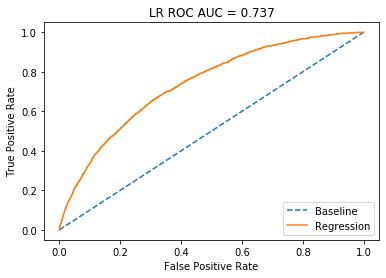

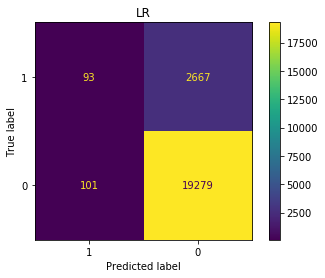

In [54]:
model = LogisticRegression()
split_and_grade(X,y,model,'LR', show_graphics=True)

Тренировка модели LR with balanced weight
   accuracy: 0.6681571815718157
   roc auc: 0.7370618708963371
   precision: 0.22483503299340132
   recall: 0.6789855072463769
   f1: 0.33780982424515543


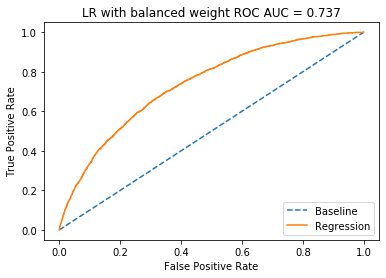

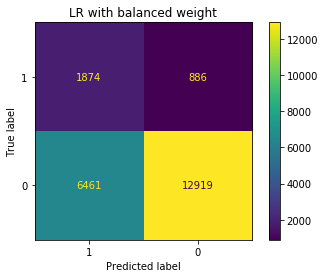

In [55]:
model = LogisticRegression(class_weight='balanced')
split_and_grade(X,y,model,'LR with balanced weight', show_graphics=True)

Модели дают принципиально разные данные в зависимости от параметра class_weight  
При сбалансированности сильно падает accuracy, precision, но сильно вырастает recall и f1  
Для нашей бизнес задачи важанее именно параметр recall (Мы хотим найти как можно большее количество потенциальных невыплат)

Поэтому выбираем второй вариант обучения для модели

## Выбираем гиперпараметры модели

In [56]:
model = LogisticRegression(random_state=RANDOM_SEED, class_weight='balanced', max_iter=50, tol=1e-3)


param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear'], 
     'C':[0.1, 0.5, 0.8, 1, 2]},
    {'penalty': ['l2'], 
     'C':[0.1, 0.5, 0.8, 1, 2]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1, cv=5)
gridsearch.fit(X, y)

model = gridsearch.best_estimator_
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))


    

	C: 0.1
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 13
	solver: 'lbfgs'
	tol: 0.001
	verbose: 0
	warm_start: False


In [57]:
best_model = LogisticRegression(random_state=RANDOM_SEED, class_weight='balanced', C=0.1, penalty='l2')

In [58]:
split_and_grade(X, y, best_model)

Тренировка модели None
   accuracy: 0.6681120144534779
   roc auc: 0.7370518501069382
   precision: 0.22480806142034548
   recall: 0.6789855072463769
   f1: 0.3377793799567411


Через сетку параметров сделаем выбор модели, которая дает лучший roc_auc  
Изменяем параметры penalty&solver и С (коэффициент регуляризации)

По результатам подбора параметров видно, что не сильно нам помогла регуляризация
roc_auc стал даже хуже чем в простой модели (но незначительно)


# Отбор параметров

Для отбора признаков можем натренировать модель LogisticRegression с L1 регуляризацией, а также Случайный лес, и посмотреть какие признаки будут менее востребованы

In [59]:
def show_coef_power(model):
    if hasattr(model,'coef_'):
        features = model.coef_[0]
    else:
        features =model.feature_importances_
        
    coefs = pd.DataFrame( zip(X.columns, features), columns=['param', 'value'])
    return coefs.iloc[(-np.abs(coefs['value'].values)).argsort()]
    

In [60]:
print("коэфициенты нашей лучшей модели")
show_coef_power(model)

коэфициенты нашей лучшей модели


,param,value
21,region_rating_80,-0.80
4,score_bki,0.49
16,region_rating_30,0.48
20,region_rating_70,-0.43
15,region_rating_20,0.41
28,home_address_2,0.37
25,education_SCH,0.35
17,region_rating_40,0.35
0,sex,0.30
22,education_ACD,-0.29


In [61]:
model_l1 = LogisticRegression(random_state=RANDOM_SEED, class_weight='balanced', C=0.1, penalty='l1', solver='liblinear')
model_l1.fit(X,y)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=13, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [62]:
print("коэфициенты L1")
show_coef_power(model_l1)

коэфициенты L1


,param,value
21,region_rating_80,-0.87
4,score_bki,0.49
28,home_address_2,0.49
20,region_rating_70,-0.49
25,education_SCH,0.39
16,region_rating_30,0.30
0,sex,0.30
30,work_address_1,-0.30
17,region_rating_40,0.27
13,carcartype,-0.27


In [63]:
model_forest = RandomForestClassifier(random_state=RANDOM_SEED, class_weight='balanced')
model_forest.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=13, verbose=0,
                       warm_start=False)

In [64]:
print("коэфициенты forest")
show_coef_power(model_forest)

коэфициенты forest


,param,value
4,score_bki,0.20
1,age,0.13
6,income,0.11
5,bki_request_cnt,0.07
8,first_time,0.05
7,sna,0.04
11,income_categ,0.04
14,app_month,0.03
0,sex,0.03
2,decline_app_cnt,0.02


In [65]:
split_and_grade(X, y, model_forest, 'random forest')

Тренировка модели random forest
   accuracy: 0.8748870822041553
   roc auc: 0.7071816997203153
   precision: 0.46835443037974683
   recall: 0.02681159420289855
   f1: 0.05071967100753941


Ну в заключении можно написать что особо нечего отбирать  
Логистическая регрессия с L1 регуляризаций предложило убрать 5 параметров, но особой логики в этом не вижу  
Случайный лес показал на другие параметры, которые редко использует

Вывод - не буду ничего удалять

# Сабмишн

In [66]:
best_model.fit(X, y)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=13, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [67]:
y_probs = best_model.predict_proba(X_test)[:,1]
answer = pd.Series(y_probs, name='default', index=X_test.index)
answer.to_csv('result.csv')

Натренируем нашу лучшую модель на всех данных  
Выложим решение на сайте kaggle  

Результат 0.73742